# [Dacon_FIFA 선수 이력료 예측 경진대회](https://dacon.io/competitions/open/235538/overview/description)
- 컬럼 설명
    - id : 선수 고유의 아이디
    - name : 이름
    - age : 나이
    - continent : 선수들의 국적이 포함되어 있는 대륙입니다
    - contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
    - position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
    - prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
    - reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
    - stat_overall : 선수의 현재 능력치 입니다.
    - stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
    - stat_skill_moves : 선수의 개인기 능력치 입니다.
    - value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

### 1. EDA

In [2]:
train = pd.read_csv(os.getcwd() + '/data/FIFA/FIFA_train.csv').drop('id', axis=1)
display(train.head(3))
print(train.shape)
print(train.info())
print(train.isna().sum().sum()) # 0개

,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0


(8932, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              8932 non-null   object 
 1   age               8932 non-null   int64  
 2   continent         8932 non-null   object 
 3   contract_until    8932 non-null   object 
 4   position          8932 non-null   object 
 5   prefer_foot       8932 non-null   object 
 6   reputation        8932 non-null   float64
 7   stat_overall      8932 non-null   int64  
 8   stat_potential    8932 non-null   int64  
 9   stat_skill_moves  8932 non-null   float64
 10  value             8932 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 767.7+ KB
None
0


In [12]:
train.describe()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


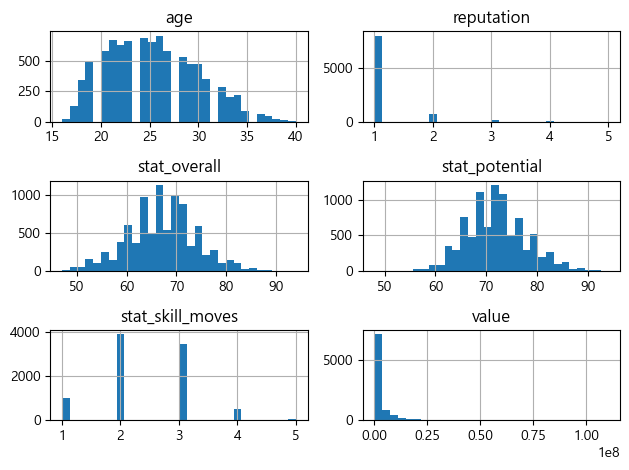

In [13]:
train.hist(bins=30)
plt.tight_layout()
plt.show()

In [14]:
train['continent'].value_counts()

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64

In [15]:
train['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

In [3]:
# contract_until 전처리(연도 정보만 남기기)
def make_year(x):
    if len(x) > 4:
        return int(x[-4:])
    else: return int(x)
    
train['contract_year'] = train['contract_until'].apply(make_year)
train['contract_year'].value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_year, dtype: int64

In [16]:
train['position'].value_counts()

MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64

In [17]:
train['prefer_foot'].value_counts()

right    6837
left     2095
Name: prefer_foot, dtype: int64

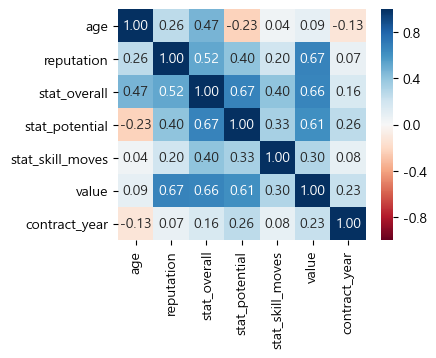

In [35]:
train_corr = train.corr()
plt.figure(figsize=(4,3))
sns.heatmap(train_corr, vmin=-1, vmax=1, cmap='RdBu', annot=True, fmt='.2f');

1. 결측치 존재 여부
    - 전체 데이터에 결측치는 존재하지 않는다.
1. 데이터 타입 구성
    - 종속변수 value는 float형, 독립변수는 object, int, float형으로 구성되어 있다.
1. 종속변수와 독립변수 간 상관관계
    - 상관관계 히트맵을 확인한 결과, value와 가장 높은 상관성을 갖는 독립변수는 reputation이고 이때 상관계수는 약 0.67로 나타났다.
1. 독립변수 간 상관관계
    - 독립변수 간 상관관계를 확인한 결과, 다중공선성을 의심할 정도(약 0.9)의 상관관계는 존재하지 않았다.
1. 주의할 점
    - contract_until 변수는 값의 형태가 통일되지 않아서 연도 정보만 추출하여 contract_year라는 새로운 변수를 생성하였다.
    - 모델 구현시, contract_year는 순서형 변수이므로 원핫인코딩을 적용해야 할 것이다.

### 2. 통계 분석

#### 1) t-test(유의수준 0.95, 모분산 모름)
- 귀무가설: 선수들의 평균 능력치는 85이다.
- 대립가설: 선수들의 평균 능력치는 85보다 낮다.

In [4]:
import scipy.stats as stats
np.random.seed(1234)
a = np.random.choice(train['stat_overall'], 23)
stats.shapiro(a) # 정규성 만족
print(stats.ttest_1samp(a, popmean=85, alternative='less')) # 귀무가설 기각
print('신뢰구간:', stats.t.interval(alpha=0.95, df=len(a)-1, loc=np.mean(a),
                 scale=stats.sem(a)))

Ttest_1sampResult(statistic=-12.67567567567568, pvalue=6.893227191708033e-12)
신뢰구간: (61.27246506467614, 67.94492623967167)


#### 2) 독립표본 t-test
- 귀무가설: 아시아와 아프리카 선수들 간 유명한 정도에 차이가 없다.
- 대립가설: 아시아와 아프리카 선수들 간 유명한 정도에 차이가 있다.

In [65]:
np.random.seed(1234)
asia = np.random.choice(train.loc[train['continent']=='asia', 'reputation'], 60)
africa = np.random.choice(train.loc[train['continent']=='africa', 'reputation'], 72)
stats.shapiro(asia) # 정규성 불만족
stats.shapiro(africa) # 정규성 불만족
stats.levene(asia, africa) # 등분산성 만족
print(stats.mannwhitneyu(asia, africa)) # 귀무가설 채택

MannwhitneyuResult(statistic=1998.0, pvalue=0.16685089020233357)


In [66]:
def sp(data1, data2):
    df = len(data1) + len(data2)
    s1 = (len(data1)-1) * (data1.std()**2)
    s2 = (len(data2)-1) * (data2.std()**2)
    sp = np.sqrt((s1+s2)/df)
    return sp
alpha=0.95
dof = len(asia) + len(africa) - 2
diff_mean = np.mean(asia)-np.mean(africa)
s = sp(asia, africa)*(1/len(asia)+1/len(africa))
cl=stats.t.interval(alpha, dof, loc=diff_mean, scale=s)
print('신뢰구간:', cl)

신뢰구간: (-0.13747362891149909, -0.09030414886627877)


#### 3) 일원배치 분산분석
- 귀무가설: 선수가 선호하는 포지선에 따라 이적료에 차이가 없다.
- 대립가설: 적어도 하나의 선수가 선호하는 포지션에 따라 이적료에 차이가 있다.

group1,group2,meandiff,p-adj,lower,upper,reject
DF,GK,-312274.4913,0.462,-861916.0805,237367.0979,False
DF,MF,817414.0563,0.0,436071.672,1198756.4407,True
DF,ST,1026012.7998,0.0,566258.1127,1485767.487,True
GK,MF,1129688.5476,0.0,593768.2324,1665608.8629,True
GK,ST,1338287.2911,0.0,744012.1507,1932562.4315,True
MF,ST,208598.7435,0.621,-234660.8645,651858.3514,False


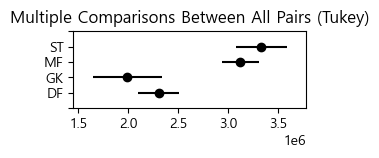

In [84]:
for pos in ['MF', 'DF', 'ST', 'GK']:
    globals()['{}_sample'.format(pos)] = \
    train.loc[train['position']==pos, 'value'] # 샘플 생성

# for pos in ['MF', 'DF', 'ST', 'GK']:
#     print(stats.shapiro(globals()['{}_sample'.format(pos)])) # 전부 정규성 불만족
    
# print(stats.levene(MF_sample, DF_sample, ST_sample, GK_sample)) # 등분산성 불만족

stats.kruskal(MF_sample, DF_sample, ST_sample, GK_sample) # 귀무가설 기각

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mc = MultiComparison(data=train['value'], groups=train['position'])
tukeyhsd = mc.tukeyhsd(alpha=.05)
fig = tukeyhsd.plot_simultaneous(figsize=(3,1))
display(tukeyhsd.summary())

#### 4) 회귀분석

In [85]:
train.head(2)

,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year
0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,2021
1,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,2020


In [23]:
feature_nm = train.columns.drop(['name', 'contract_until', 'value'])
feature_nm = [name for name in feature_nm]

import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.ols(formula='value ~' + "+".join(feature_nm), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1196.
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:16:21   Log-Likelihood:            -1.4712e+05
No. Observations:                8932   AIC:                         2.943e+05
Df Residuals:                    8917   BIC:                         2.944e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

- 범주형 변수는 더미변수로 치환, 연속형 변수는 스케일링을 하여 다시 회귀분석 하였다(아래).

In [48]:
from sklearn.preprocessing import StandardScaler
train_drop = train.drop(['name', 'contract_until'], axis=1)
train_dum = pd.get_dummies(data=train_drop, columns=['continent', 'position', 'prefer_foot', 'contract_year'], drop_first=True)
train_sc = train_dum.copy()
scaler = StandardScaler()
train_sc.iloc[:, :5] = scaler.fit_transform(train_sc.iloc[:, :5])
train_sc.rename(columns = {'continent_south america' : 'continent_south_america'}, inplace = True)

features = "+".join([nm for nm in train_sc.columns])
model = smf.ols(formula='value ~' + features, data=train_sc)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.373e+32
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:27:03   Log-Likelihood:             1.5183e+05
No. Observations:                8932   AIC:                        -3.036e+05
Df Residuals:                    8909   BIC:                        -3.035e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

### 3. 머신러닝
#### 1) kfold 교차 검증을 수행하시오.
#### 2) 범주형 변수는 더미 변수로 치환하여 모델을 학습하시오.
    - 기준변수: continent('europe'), contract_year('2019'), position('ST'), prefer_foot('left')

In [78]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import time

# 데이터 전처리
train_drop = train.drop(['name', 'contract_until'], axis=1)
train_drop.head(2)
train_dum = pd.get_dummies(columns=['continent', 'position', 'prefer_foot', 'contract_year'], 
                           data=train_drop)
train_dum.drop(['continent_europe', 'contract_year_2019', 'position_ST', 'prefer_foot_left'], 
               axis=1, inplace=True)
train_dum.head(3)

# 데이터 분할
X = train_dum.drop('value', axis=1)
y = train_dum.value

# KFold 사용자 정의 함수 생성(cv=5)
kfold=KFold()
def model_result(model):
    pred_li = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        
        pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(pred, y_test))
        pred_li.append(rmse)
        
    print(f'### {model.__class__.__name__} ###')
    print(f'time: {end-start} sec')
    print(f'평균 RMSE: {round(np.mean(pred_li),4)}')
    
# 모델 객체 생성
rfr_reg = RandomForestRegressor(random_state=123)
xgb_reg = XGBRegressor(random_state=123)
lgbm_reg = LGBMRegressor(random_state=123)

In [77]:
model_result(rfr_reg)
model_result(xgb_reg)
model_result(lgbm_reg)

### RandomForestRegressor ###
time: 4.2838873863220215 sec
평균 RMSE: 2486207.195
### XGBRegressor ###
time: 2.7109153270721436 sec
평균 RMSE: 2496808.6933
### LGBMRegressor ###
time: 1.5722835063934326 sec
평균 RMSE: 2470924.7896
